Cat Dog Classification
===

In [2]:
import tensorflow as tf
import os
import re
import numpy as np
import zipfile
import matplotlib.pyplot as plt

from tensorflow.contrib import learn
from tensorflow.contrib.learn.python.learn.estimators import model_fn as model_fn_lib
from tensorflow.contrib.learn import RunConfig as run_config

slim = tf.contrib.slim

### Utility function
Image reader, Input pipeline, etc.

In [3]:
CAT = 0
DOG = 1
IS_LOW_MEMORY_MODE = True

TRAIN_DATA_SIZE = None

cwd = os.getcwd()
np.random.seed(2124)

In [4]:
def prepare_file():
  file_list = ['train', 'test']
  valid = True

  for i in range(len(file_list)):
    filename = file_list[i] + '.zip'
    dest_filename = os.path.join(cwd, 'data', filename)

    if not os.path.exists(dest_filename):
      print('Please download ' + filename + ' and put on src/data folder')
      url = "https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/download/"
      print(url + filename)
      valid = False
      continue
    
    images_path = os.path.join(cwd, 'data', file_list[i])

    zip = zipfile.ZipFile(dest_filename)
    if not os.path.exists(images_path):
        print('Extracting...')
        zip.extractall(os.path.join(cwd, 'data'))
      
  return valid

def read_image_label_list(folder_dir):
    dir_list = os.listdir(os.path.join(cwd, folder_dir))
    
    filenames = []
    labels = []
    
    for i, d in enumerate(dir_list):
        if re.search("train", folder_dir):
            if re.search("cat", d):
                labels.append(CAT)
            else:
                labels.append(DOG)
        else:
            labels.append(-1)
        filenames.append(os.path.join(cwd, folder_dir, d))
    
    return filenames, labels

def read_images_from_disk(input_queue):
    filename = input_queue[0]
    label = input_queue[1]
    
    file_contents = tf.read_file(filename)
    image = tf.image.decode_image(file_contents, channels=3)
    image.set_shape([None, None, 3])
    
    return image, label

def gen_input_fn(image_list, label_list, batch_size, shuffle):
    
    def input_fn():
        images = tf.convert_to_tensor(image_list, dtype=tf.string)
        labels = tf.convert_to_tensor(label_list, dtype=tf.int32)

        input_queue = tf.train.slice_input_producer(
            [images, labels],
            capacity=batch_size * 5,
            shuffle=shuffle,
            name="file_input_queue"
        )

        image, label = read_images_from_disk(input_queue)

        image = tf.image.resize_images(image, (224, 224), tf.image.ResizeMethod.NEAREST_NEIGHBOR)

        image_batch, label_batch = tf.train.batch(
            [image, label],
            batch_size=batch_size,
            num_threads=1,
            name="batch_queue",
            capacity=batch_size * 10,
            allow_smaller_final_batch = False
        )
        
        return (
            tf.identity(image_batch, name="features"), 
            tf.identity(label_batch, name="label")
        )

    return input_fn

def train_valid_input_fn(data_dir, train_batch_size, valid_batch_size=None):
    img, labels = read_image_label_list(data_dir)
    img = np.array(img)
    labels = np.array(labels)
    data_size = img.shape[0]

    print("Data size: " + str(data_size))
    split = int(0.7 * data_size)

    random_seq = np.random.permutation(data_size)

    img = img[random_seq]
    labels = labels[random_seq]
    
    if valid_batch_size == None:
        valid_batch_size = train_batch_size

    return (
        gen_input_fn(img[0:split], labels[0:split], train_batch_size, shuffle = True),
        gen_input_fn(img[split:], labels[split:], valid_batch_size, shuffle = False)
    )

def test_input_fn(data_dir, batch_size):
    image_list, label_list = read_image_label_list(data_dir)
    return gen_input_fn(image_list, label_list, batch_size, shuffle = False), image_list

### Preview Data
Check correctness of data

In [5]:
if prepare_file():
    print "Files are ready \o/"

Files are ready \o/


Data size: 25000


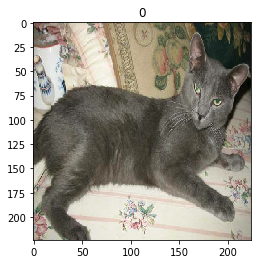

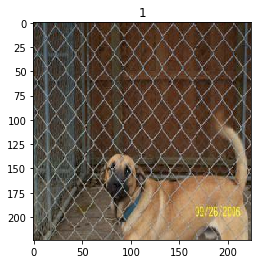

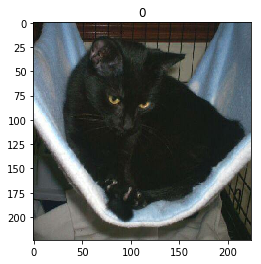

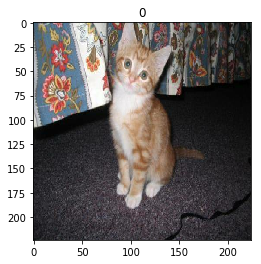

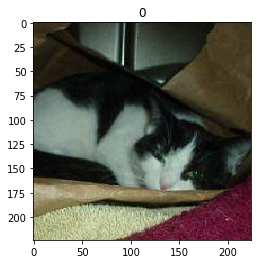

In [6]:
def plot_img(data, label=None):
    plt.ion()
    plt.figure()
    plt.imshow(data)
    if label is not None:
        plt.title(label)

def preview_img():
    
    img_preview = tf.Graph()
    
    with img_preview.as_default():
        tensor_train, _ = train_valid_input_fn('data/train', 5)
        result = tf.tuple(tensor_train())
        
    with tf.Session(graph=img_preview) as sess:
        sess.run(tf.global_variables_initializer())
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=coord)

        images, labels = sess.run(result)
        for i in range(len(images)):
            plot_img(images[i], str(labels[i]))

        coord.request_stop()
        coord.join(threads)

        sess.close()

preview_img()

### Define Model
Create a model for using in Estimator

In [7]:
def create_model(inputs, is_training):
    with tf.variable_scope('model', values=[inputs]):
        with slim.arg_scope(
            [slim.conv2d, slim.fully_connected],
            activation_fn=tf.nn.relu6,
            weights_initializer=tf.truncated_normal_initializer(0.0, 0.01),
            weights_regularizer=slim.l2_regularizer(0.0005)):
            
            net = inputs
        
            if IS_LOW_MEMORY_MODE == False:
                net = slim.repeat(net, 2, slim.conv2d, 64, [3, 3], scope='conv1')
                net = slim.max_pool2d(net, [2, 2], scope='pool1')

                net = slim.repeat(net, 2, slim.conv2d, 128, [3, 3], scope='conv2')
                net = slim.max_pool2d(net, [2, 2], scope='pool2')

                net = slim.repeat(net, 4, slim.conv2d, 256, [3, 3], scope='conv3')
                net = slim.max_pool2d(net, [2, 2], scope='pool3')
                net = slim.repeat(net, 4, slim.conv2d, 512, [3, 3], scope='conv4')
                net = slim.max_pool2d(net, [2, 2], scope='pool4')
                net = slim.repeat(net, 4, slim.conv2d, 512, [3, 3], scope='conv5')
                net = slim.max_pool2d(net, [2, 2], scope='pool5')

                net = tf.reshape(net, [-1, 7 * 7 * 512])

                net = slim.fully_connected(net, 2048, scope='fc6')
                net = slim.dropout(net, 0.5, is_training=is_training, scope='dropout6')

                net = slim.fully_connected(net, 2048, scope='fc7')
                net = slim.dropout(net, 0.5, is_training=is_training, scope='dropout7')
                
            else:
                # Model for my Mac T_T
                net = tf.image.resize_images(net, (72, 72), tf.image.ResizeMethod.NEAREST_NEIGHBOR)
                
                net = slim.repeat(net, 1, slim.conv2d, 64, [3, 3], scope='conv1')
                net = slim.max_pool2d(net, [2, 2], scope='pool1')
                
                net = slim.repeat(net, 1, slim.conv2d, 128, [3, 3], scope='conv2')
                net = slim.max_pool2d(net, [2, 2], scope='pool2')
                
                net = slim.repeat(net, 2, slim.conv2d, 256, [3, 3], scope='conv3')
                net = slim.max_pool2d(net, [2, 2], scope='pool3')
                
                net = tf.reshape(net, [-1, 9 * 9 * 256])
                
                net = slim.fully_connected(net, 1024, scope='fc4')
                net = slim.dropout(net, 0.5, is_training=is_training, scope='dropout4')

                net = slim.fully_connected(net, 1024, scope='fc5')
                net = slim.dropout(net, 0.5, is_training=is_training, scope='dropout5')

            net = slim.fully_connected(net, 1, activation_fn=None, scope='fc6')
            net = tf.reshape(net, [-1])
            
            return net

In [8]:
def model_fn(features, labels, mode, params):
    
    is_training = False
    if mode == learn.ModeKeys.TRAIN:
        is_training = True
    
    labels = tf.cast(labels, tf.float32)
    
    output = create_model(features, is_training)
    output = tf.minimum(output, tf.ones([output.shape[0]]))
    
    loss = None
    train_op = None
    eval_metric_ops = None
    
    if mode != learn.ModeKeys.INFER:
        loss = tf.reduce_sum(tf.abs(labels - output), name = 'loss_tensor')
        
    if mode == learn.ModeKeys.TRAIN:
        train_op = tf.contrib.layers.optimize_loss(
            loss = loss,
            global_step = tf.contrib.framework.get_global_step(),
            learning_rate = params['learning_rate'],
            optimizer = 'Adam'
        )
    
    if mode != learn.ModeKeys.INFER:
        log_loss = tf.identity(
            tf.losses.log_loss(
                labels,
                output,
                reduction = tf.losses.Reduction.MEAN
            ),
            name = 'log_loss_tensor'
        )
        eval_metric_ops = {
            'log_loss': log_loss,
            'loss': loss
        }
        
    predictions = {
        'predict': output
    }
    
    return model_fn_lib.ModelFnOps(
        mode = mode,
        predictions = predictions,
        loss = loss,
        train_op = train_op,
        eval_metric_ops = eval_metric_ops
    )

Define model classifier

In [12]:
def feature_engineering_fn(features, labels):
    features = tf.to_float(features)
    features = tf.map_fn(tf.image.per_image_standardization, features)

    return features, labels

tf.logging.set_verbosity(tf.logging.WARN)

model_path = '_model/model_low' if IS_LOW_MEMORY_MODE else '_model/model_full'
classifier = learn.Estimator(
    model_fn = model_fn, 
    model_dir = model_path + '_v2',
    config = run_config(
        save_summary_steps = 10,
        keep_checkpoint_max = 3,
        save_checkpoints_steps = 100
    ),
    feature_engineering_fn = feature_engineering_fn,
    params = {
        'learning_rate': 0.001
    }
)

train_input_fn, validate_input_fn = train_valid_input_fn('data/train', 32, 64)

logging_hook = tf.train.LoggingTensorHook(
    tensors = {
        'log_loss': 'log_loss_tensor',
        'loss': 'loss_tensor'
    }, 
    every_n_iter = 3
)

validation_monitor = tf.contrib.learn.monitors.ValidationMonitor(
    input_fn = validate_input_fn,
    eval_steps = 50,
    every_n_steps = 10,
    name = 'Validatation'
)

Data size: 25000
Instructions for updating:
Monitors are deprecated. Please use tf.train.SessionRunHook.


Let its trainnnn !!!

In [ ]:
tf.logging.set_verbosity(tf.logging.INFO)

classifier.fit(
    input_fn = train_input_fn,
    steps = 12000,
    monitors = [logging_hook, validation_monitor]
)

In [ ]:
classifier.evaluate(
    input_fn = validate_input_fn,
    steps = 100
)

Let's predicttt !!!

In [ ]:
test_fn, image_test_list = test_input_fn('data/test', 32)
test_n = len(image_test_list)

print("Test size: %d" % test_n)

result_file = open(os.path.join(cwd, 'result/result.txt'), 'w+')
result_file.write('id,label\n')

predictions = classifier.predict(input_fn = test_fn, as_iterable=True)
for i, p in enumerate(predictions):
    if i >= test_n:
        break
        
    id = image_test_list[i].split("/")[-1]
    id = id.split(".")[0]

    if i % 100 == 0:
        print("Predict %d %s: %s" % (i, image_test_list[i], p["classes"]))

    result_file.write("%s,%s\n" % (id, p["classes"]))

result_file.flush()
result_file.close()
print('Finish!!')